In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from koopmaneigen.koopman_eigensolver import KoopmanEigenSolvers
from koopmaneigen.linearsystem import Linear2dSystem

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis

### set up linear system Koopman matrix using EDMD

In [3]:
A = np.array([[0.9, -0.1], [0, 0.8]])

eigvalue_i = 0.9
eigvalue_j = 0.8

def eigenfunction_i(x,y):
    return (x-y)/np.sqrt(2)

def eigenfunction_j(x,y):
    return y    

linear_system = Linear2dSystem(A, eigvalue_i, eigvalue_j, eigenfunction_i, eigenfunction_j)

In [4]:
initial_conditions = np.array(
    np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
).T.reshape(-1, 2)


initial_conditions.shape

(400, 2)

In [5]:
tsc_data = linear_system.sample_system(initial_conditions)
print(tsc_data.shape)
tsc_data.head()

(800, 2)


feature        x1        x2
ID time                    
0  0    -2.000000 -2.000000
   1    -1.600000 -1.600000
1  0    -2.000000 -1.789474
   1    -1.621053 -1.431579
2  0    -2.000000 -1.578947

In [6]:
dict_step = [
    (
        "polynomial",
        TSCPolynomialFeatures(degree=3),
    )
]

edmd_poly = EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_data)
edmd_poly_values = edmd_poly.predict(tsc_data.initial_states())

In [7]:
edmd_poly.feature_names_out_

Index(['x1', 'x2', 'x1^2', 'x1 x2', 'x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2',
       'x2^3'],
      dtype='object', name='feature')

#### plot explicit koopman eigenfunctions of the linear system

In [8]:
sorted_eig = linear_system.get_sorted_eigvalues()
sorted_eig

[(1, 0), (2, 0), (0, 1), (3, 0), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]

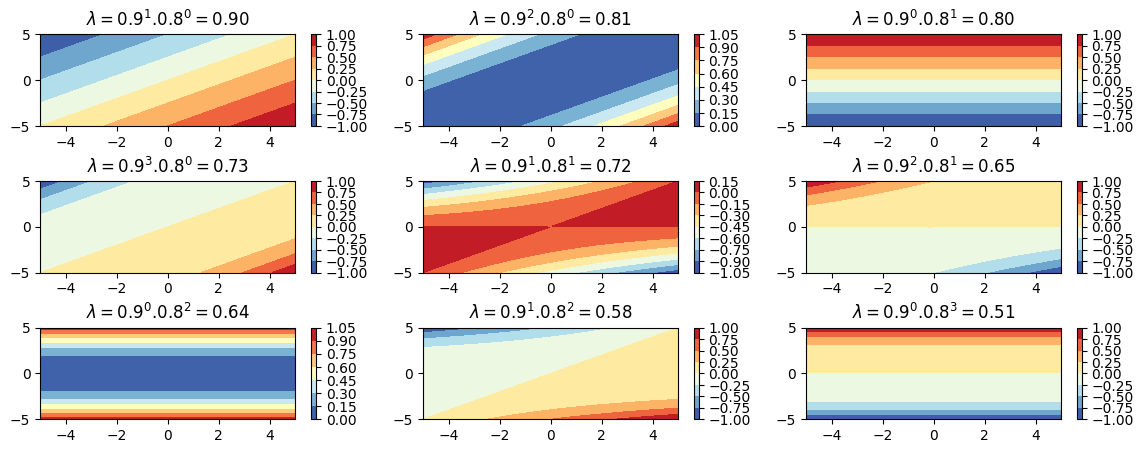

In [9]:
f, ax = plt.subplots(3, 3, figsize=(14, 5))
plt.subplots_adjust(hspace=0.6)

def plot_eigenfunction_contour(m, n, ax):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    Z = linear_system.generate_eigenfunction(X, Y, m,n)
    Z = Z/np.max(np.abs(Z))

    h = ax.contourf(X, Y, Z, cmap='RdYlBu_r')
    eig = (eigvalue_i)**m * (eigvalue_j) ** n
    eig_str = f"$\lambda = {eigvalue_i}^{m} . {eigvalue_j}^{n} = {eig:0.2f}$"
    
    ax.set_title(eig_str)
    plt.colorbar(h)    
    return ax
    
for i, (m,n) in enumerate(sorted_eig):
    plot_eigenfunction_contour(m=m, n=n,  ax = ax[int(i/3)][i%3])



### plot Koopman eigenfunctions computed using left eigenvectors

In [10]:
koopman_eigen = KoopmanEigenSolvers(edmd_poly, tsc_data)
print("shape of koopman matrix: ", koopman_eigen.koopman_matrix.shape)

shape of koopman matrix:  (9, 9)


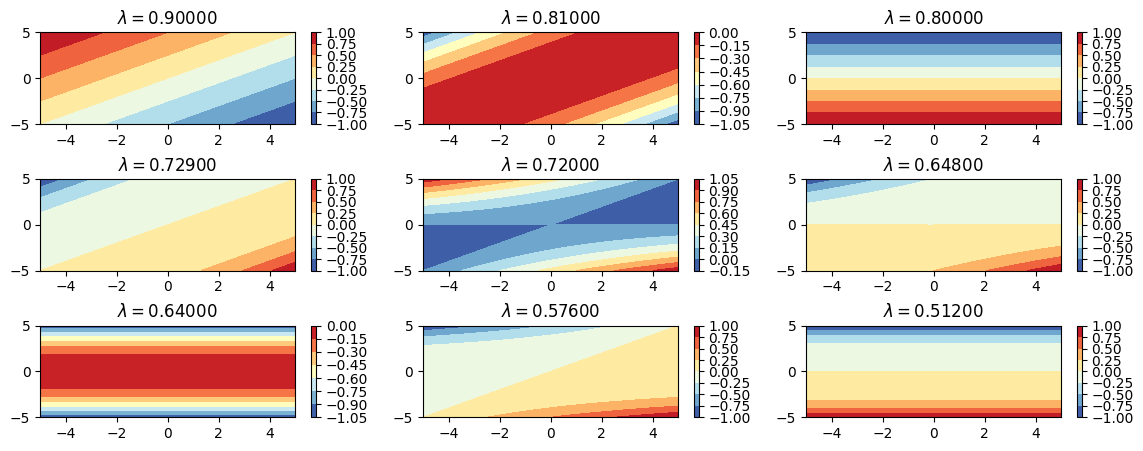

In [11]:
f, ax = plt.subplots(3, 3, figsize=(14, 5))
plt.subplots_adjust(hspace=0.6)

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
x_flat = X.flatten()
y_flat = Y.flatten()
x = np.array([X.flatten(), Y.flatten()]).T

koopman_eigenfunctions_eval = koopman_eigen.eigenfunction_left(koopman_eigen.left_koopman_eigvecs)(x)

for i in range(koopman_eigenfunctions_eval.shape[1]):
    
    Z = koopman_eigenfunctions_eval[:, i]
    Z = Z/np.max(np.abs(Z))
    
    h = ax[int(i/3)][i%3].contourf(X, Y, np.array(Z).reshape(100,100), cmap='RdYlBu_r')
    eig = koopman_eigen.left_koopman_eigvals[i]

    ax[int(i/3)][i%3].set_title(f"$\lambda = {eig:.5f}$")
    plt.colorbar(h)    

#### extend eigenfunctions using two left eigenvectors

In [12]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

x = np.array([X.flatten(), Y.flatten()]).T
print(x.shape)
koopman_eigen.extend_eigenfunctions(x, eigenvector_indexes=[0,2], pow_i=2, pow_j=4)

(10000, 2)


array([6.71278041e-28, 1.02030405e-04, 4.08121620e-04, ...,
       4.08121620e-04, 1.02030405e-04, 3.42875302e-28])

#### compare extended eigenfunctions with explicit eigenfunctions

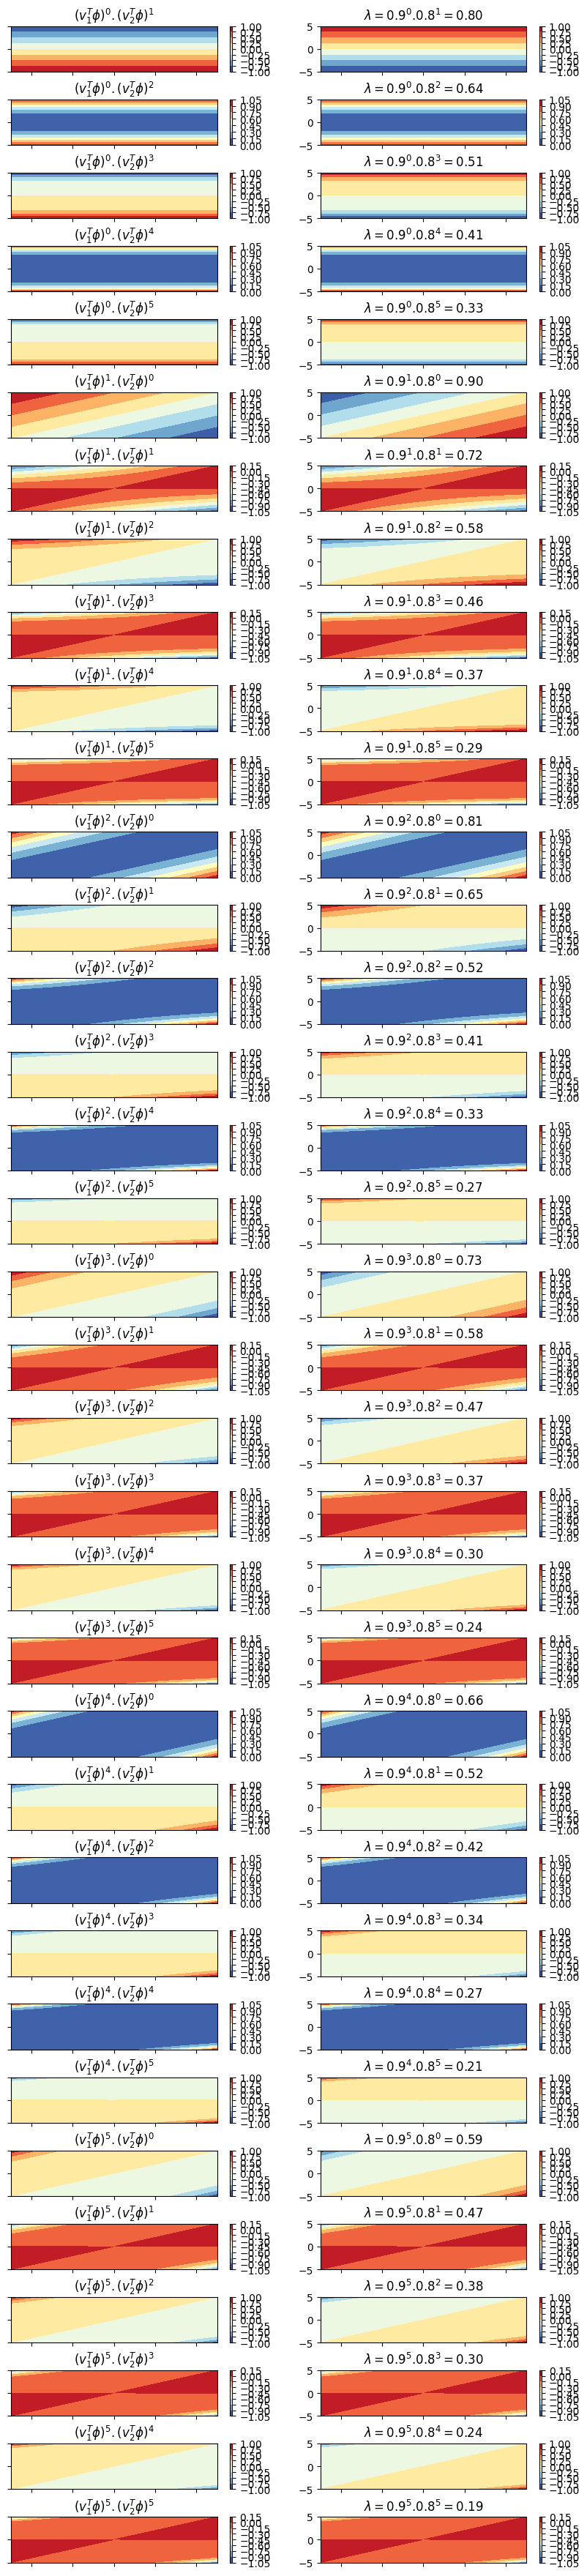

In [13]:
f, ax = plt.subplots(6*6-1, 2, figsize=(10,45))
plt.subplots_adjust(hspace=0.6)

c = 0
for i in range(0,6):
    for j in range(0,6):
         
        if i+j==0:
            continue

        Z_l = koopman_eigen.extend_eigenfunctions(x, eigenvector_indexes=[0,2], pow_i=i, pow_j=j)
        Z_l = Z_l/np.max(np.abs(Z_l))

        h = ax[c][0].contourf(X, Y, np.array(Z_l).reshape(100,100), cmap='RdYlBu_r')
        ax[c][0].set_title(f"$(v_1^T \phi)^{i} . (v_2^T \phi)^{j} $")
        ax[c][0].set_xticklabels([])
        ax[c][0].set_yticklabels([])

        plt.colorbar(h) 
        
        ax_ = plot_eigenfunction_contour(m=i, n=j,  ax = ax[c][1])
        ax_.set_xticklabels([])
        ax_.set_xticklabels([])
        
        c +=1
        
plt.show()

### reconstructing observables using new eigenfunctions

In [14]:
sinx_df = np.sin(tsc_data).to_numpy()
sinx_df.shape

(800, 2)

#### reconstruct sinx using in-sample data

In [15]:
eigfunc_matrix = koopman_eigen.eigenfunction_left(koopman_eigen.left_koopman_eigvecs)(tsc_data.to_numpy())
eigfunc_matrix.shape

(800, 9)

In [16]:
sinx_recons_df = koopman_eigen.reconstruct_observable(sinx_df, eigfunc_matrix)
sinx_recons_df.shape

(800, 2)

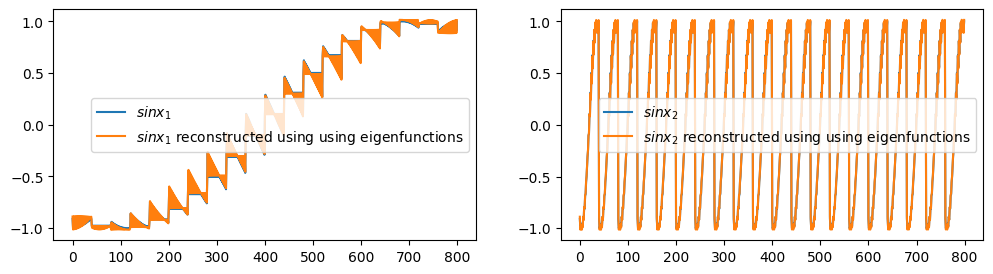

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

ax[0].plot(sinx_df[:,0], label="$sin x_1$")
ax[0].plot(sinx_recons_df[:,0], label="$sinx_1$ reconstructed using using eigenfunctions")
ax[0].legend()

ax[1].plot(sinx_df[:,1], label="$sinx_2$")
ax[1].plot(sinx_recons_df[:,1], label="$sinx_2$ reconstructed using using eigenfunctions")
ax[1].legend()


#### reconstruct sinx using out of sample data

In [18]:
x = np.linspace(-3*np.pi, 3*np.pi, 100)
y = np.linspace(-3*np.pi, 3*np.pi, 100)

oos_grid = np.array([x, y]).T
sinx_oos_grid = np.sin(oos_grid)

eigfunc_matrix = koopman_eigen.eigenfunction_left(koopman_eigen.left_koopman_eigvecs)(oos_grid)
eigfunc_matrix.shape

(100, 9)

In [19]:
sinx_oos_recons_orig = koopman_eigen.reconstruct_observable(sinx_oos_grid, eigfunc_matrix)
sinx_oos_recons_orig.shape

(100, 2)

In [20]:
exp_pairs = [(i,j) for i in range(0,4) for j in range(0,4)]

eigfunc_matrix = koopman_eigen.extended_eigfunction_matrix(oos_grid,eigvector_idx = [0,2], exp_pairs=exp_pairs)
print(f"extended eigenfunction matrix shape: ", eigfunc_matrix.shape)

sinx_oos_recons_14 = koopman_eigen.reconstruct_observable(sinx_oos_grid, eigfunc_matrix)
print("reconstructed observable shape: ", sinx_oos_recons_14.shape)

extended eigenfunction matrix shape:  (100, 15)
reconstructed observable shape:  (100, 2)


#### reconstruct using an extended set of eigenfunctions

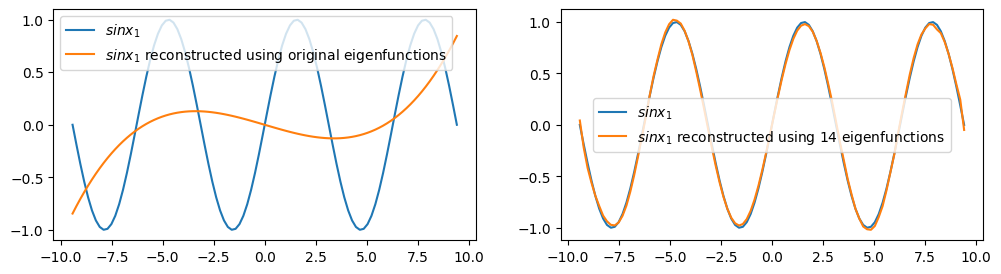

In [21]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

ax[0].plot(oos_grid[:,0], sinx_oos_grid[:,0], label="$sin x_1$")
ax[0].plot(oos_grid[:,0], sinx_oos_recons_orig[:,0], label="$sinx_1$ reconstructed using original eigenfunctions")
ax[0].legend()

ax[1].plot(oos_grid[:,0], sinx_oos_grid[:,0], label="$sin x_1$")
ax[1].plot(oos_grid[:,0], sinx_oos_recons_14[:,0], label="$sinx_1$ reconstructed using 14 eigenfunctions")
ax[1].legend()

#### reconstructing sin(x1)cos(x2)

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data for the contour plot
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

oos_grid = np.array([X.flatten(), Y.flatten()]).T
sincos_oos_grid = (np.sin(X) * np.cos(Y)).flatten()
oos_grid.shape, sincos_oos_grid.shape

((10000, 2), (10000,))

In [23]:
eigfunc_matrix = koopman_eigen.eigenfunction_left(koopman_eigen.left_koopman_eigvecs)(oos_grid)

sincos_oos_recons_orig = koopman_eigen.reconstruct_observable(sincos_oos_grid, eigfunc_matrix)
sincos_oos_recons_orig.shape

(10000,)

In [24]:
exp_pairs = [(i,j) for i in range(0,4) for j in range(0,4)]

eigfunc_matrix = koopman_eigen.extended_eigfunction_matrix(oos_grid, eigvector_idx = [0,2], exp_pairs=exp_pairs)
print("eigenfunction matrix shape: ", eigfunc_matrix.shape)

sincos_oos_recons_14 = koopman_eigen.reconstruct_observable(sincos_oos_grid, eigfunc_matrix)
print("reconstructed observable shape: ", sincos_oos_recons_14.shape)

eigenfunction matrix shape:  (10000, 15)
reconstructed observable shape:  (10000,)


In [25]:
exp_pairs = [(i,j) for i in range(0,5) for j in range(0,5)]

eigfunc_matrix = koopman_eigen.extended_eigfunction_matrix(oos_grid, eigvector_idx = [0,2], exp_pairs=exp_pairs)
print("eigenfunction matrix shape: ", eigfunc_matrix.shape)

sincos_oos_recons_24 = koopman_eigen.reconstruct_observable(sincos_oos_grid, eigfunc_matrix)
print("reconstructed observable shape: ", sincos_oos_recons_24.shape)

eigenfunction matrix shape:  (10000, 24)
reconstructed observable shape:  (10000,)


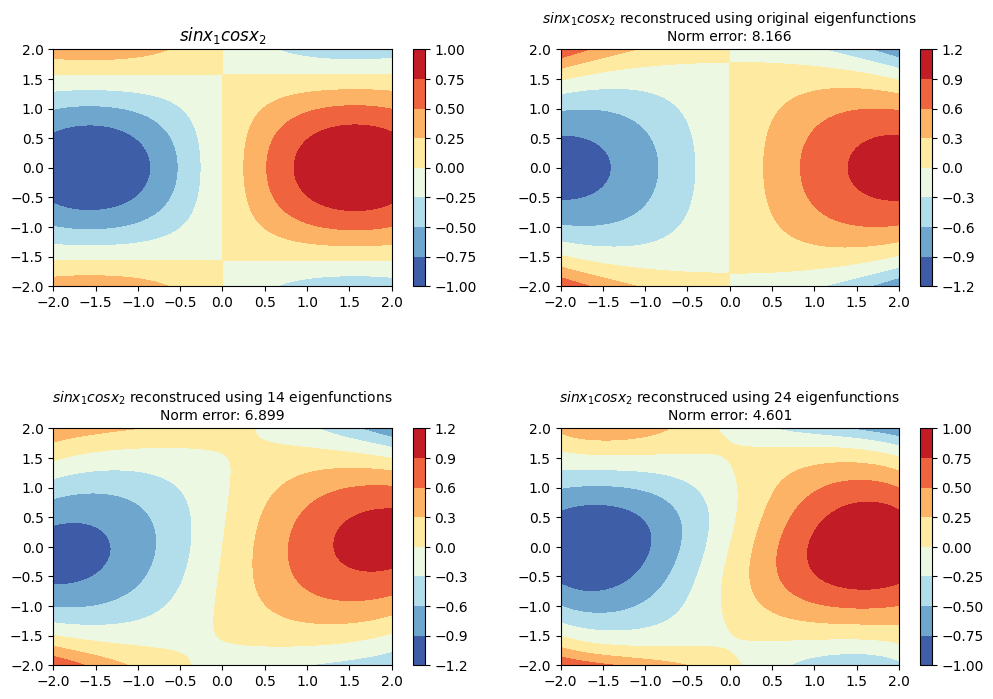

In [26]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
plt.subplots_adjust(hspace=0.6)


h = ax[0][0].contourf(X, Y, sincos_oos_grid.reshape(100,100), cmap='RdYlBu_r')
ax[0][0].set_title("$sinx_1cosx_2$")
plt.colorbar(h)

k = ax[0][1].contourf(X, Y, sincos_oos_recons_orig.reshape(100,100), cmap='RdYlBu_r')
ax[0][1].set_title(f"$sinx_1cosx_2$ reconstruced using original eigenfunctions\nNorm error: {np.linalg.norm(sincos_oos_grid-sincos_oos_recons_orig):.4}",
                   fontsize=10)
plt.colorbar(k)

l = ax[1][0].contourf(X, Y, sincos_oos_recons_14.reshape(100,100), cmap='RdYlBu_r')
ax[1][0].set_title(f"$sinx_1cosx_2$ reconstruced using 14 eigenfunctions\nNorm error: {np.linalg.norm(sincos_oos_grid-sincos_oos_recons_14):.4}",
                  fontsize=10)
plt.colorbar(l)

m = ax[1][1].contourf(X, Y, sincos_oos_recons_24.reshape(100,100), cmap='RdYlBu_r')
ax[1][1].set_title(f"$sinx_1cosx_2$ reconstruced using 24 eigenfunctions\nNorm error: {np.linalg.norm(sincos_oos_grid-sincos_oos_recons_24):.4}",
                  fontsize=10)
plt.colorbar(m)
